In [1]:
from dotenv import load_dotenv
import os
import pandas as pd
import matplotlib.pyplot as plot
from pyoso import Client

load_dotenv()
OSO_API_KEY = os.environ['OSO_API_KEY']
client = Client(api_key=OSO_API_KEY)

In [2]:
def stringify(arr):
    return "'" + "','".join(arr) + "'"

In [3]:
START_DATE = '2024-09-01'
END_DATE = '2025-03-01'

## Onchain Builders

In [4]:
df_onchain_projects = client.to_pandas(f"""
select
    p.project_id,
    p.project_name,
    p.display_name
from oso.projects_v1 p
join oso.projects_by_collection_v1 pbc on p.project_id = pbc.project_id
where pbc.collection_name = '8-1'
order by p.display_name
""")
PROJECT_IDS = list(df_onchain_projects['project_id'].unique())
df_onchain_projects.set_index('project_id', inplace=True)
df_onchain_projects.tail()

,project_name,display_name
project_id,,
VTFjeAN76kGnqTqKP+SMe2HPaIKY3wKvwo613l6OWN0=,0x098fca4a62159ddfc2c45dc2931a727d56f039b8f68e...,pods.media
1TLTRUof21yQ9U4hpzbBFOxsAYwtkoq1KsBpe3xQgtk=,0xc3a50c1784f3ac4fc8ae72d07cf0bfcf933e3d23ffb5...,remx.xyz
2d1UftVv4xC+BHialsxoPjC1WJDySvOpnH9o+3sQFYc=,0x85bef37b528ec9d7e1a9cb864e298e3c117071507acd...,rhinofi
ujotQ1D+YnXHFVrSwoa3pj8b5jOvXNPF0rfALNIG5GI=,0xe95adf2385dce0a2d8117a410d0a9adcc40710da9cd6...,tinyass unicorns
514s67lKQTp5eW88EJW1fw6fMnCv2Gi3f1c+c36aHjk=,0x59fcf753703c0f32c9d601b7f0071304819e832262ef...,youbuidl


In [5]:
METRICS = [
    f"{c.upper()}_{m}"
    for c in [  # Supported chains
        'automata', 'cyber', 'ham', 
        'base', 'bob', 'frax', 'ink', 'kroma', 'lisk', 'lyra',
        'metal', 'mint', 'mode', 'optimism', 'orderly', 'polynomial',
        'race', 'redstone', 'shape', 'soneium', 'swan', 'swell',
        'unichain', 'worldchain', 'xterio', 'zora'
    ]
    for m in [  # Metric types
        'defillama_tvl_daily',
        'gas_fees_daily',     
        'contract_invocations_daily',
        'transactions_daily',
        'active_addresses_aggregation_daily'
    ]
]

In [6]:
df_onchain_metrics = client.to_pandas(f"""
select
    tm.sample_date,
    m.display_name as metric_category,
    SUM(tm.amount) as amount
from oso.timeseries_metrics_by_project_v0 tm
join oso.metrics_v0 m on tm.metric_id = m.metric_id
where    
    tm.sample_date >= DATE('{START_DATE}') AND tm.sample_date < DATE('{END_DATE}')    
    and tm.project_id IN ({stringify(PROJECT_IDS)})
    and m.metric_name IN ({stringify(METRICS)})
group by 1,2
""")

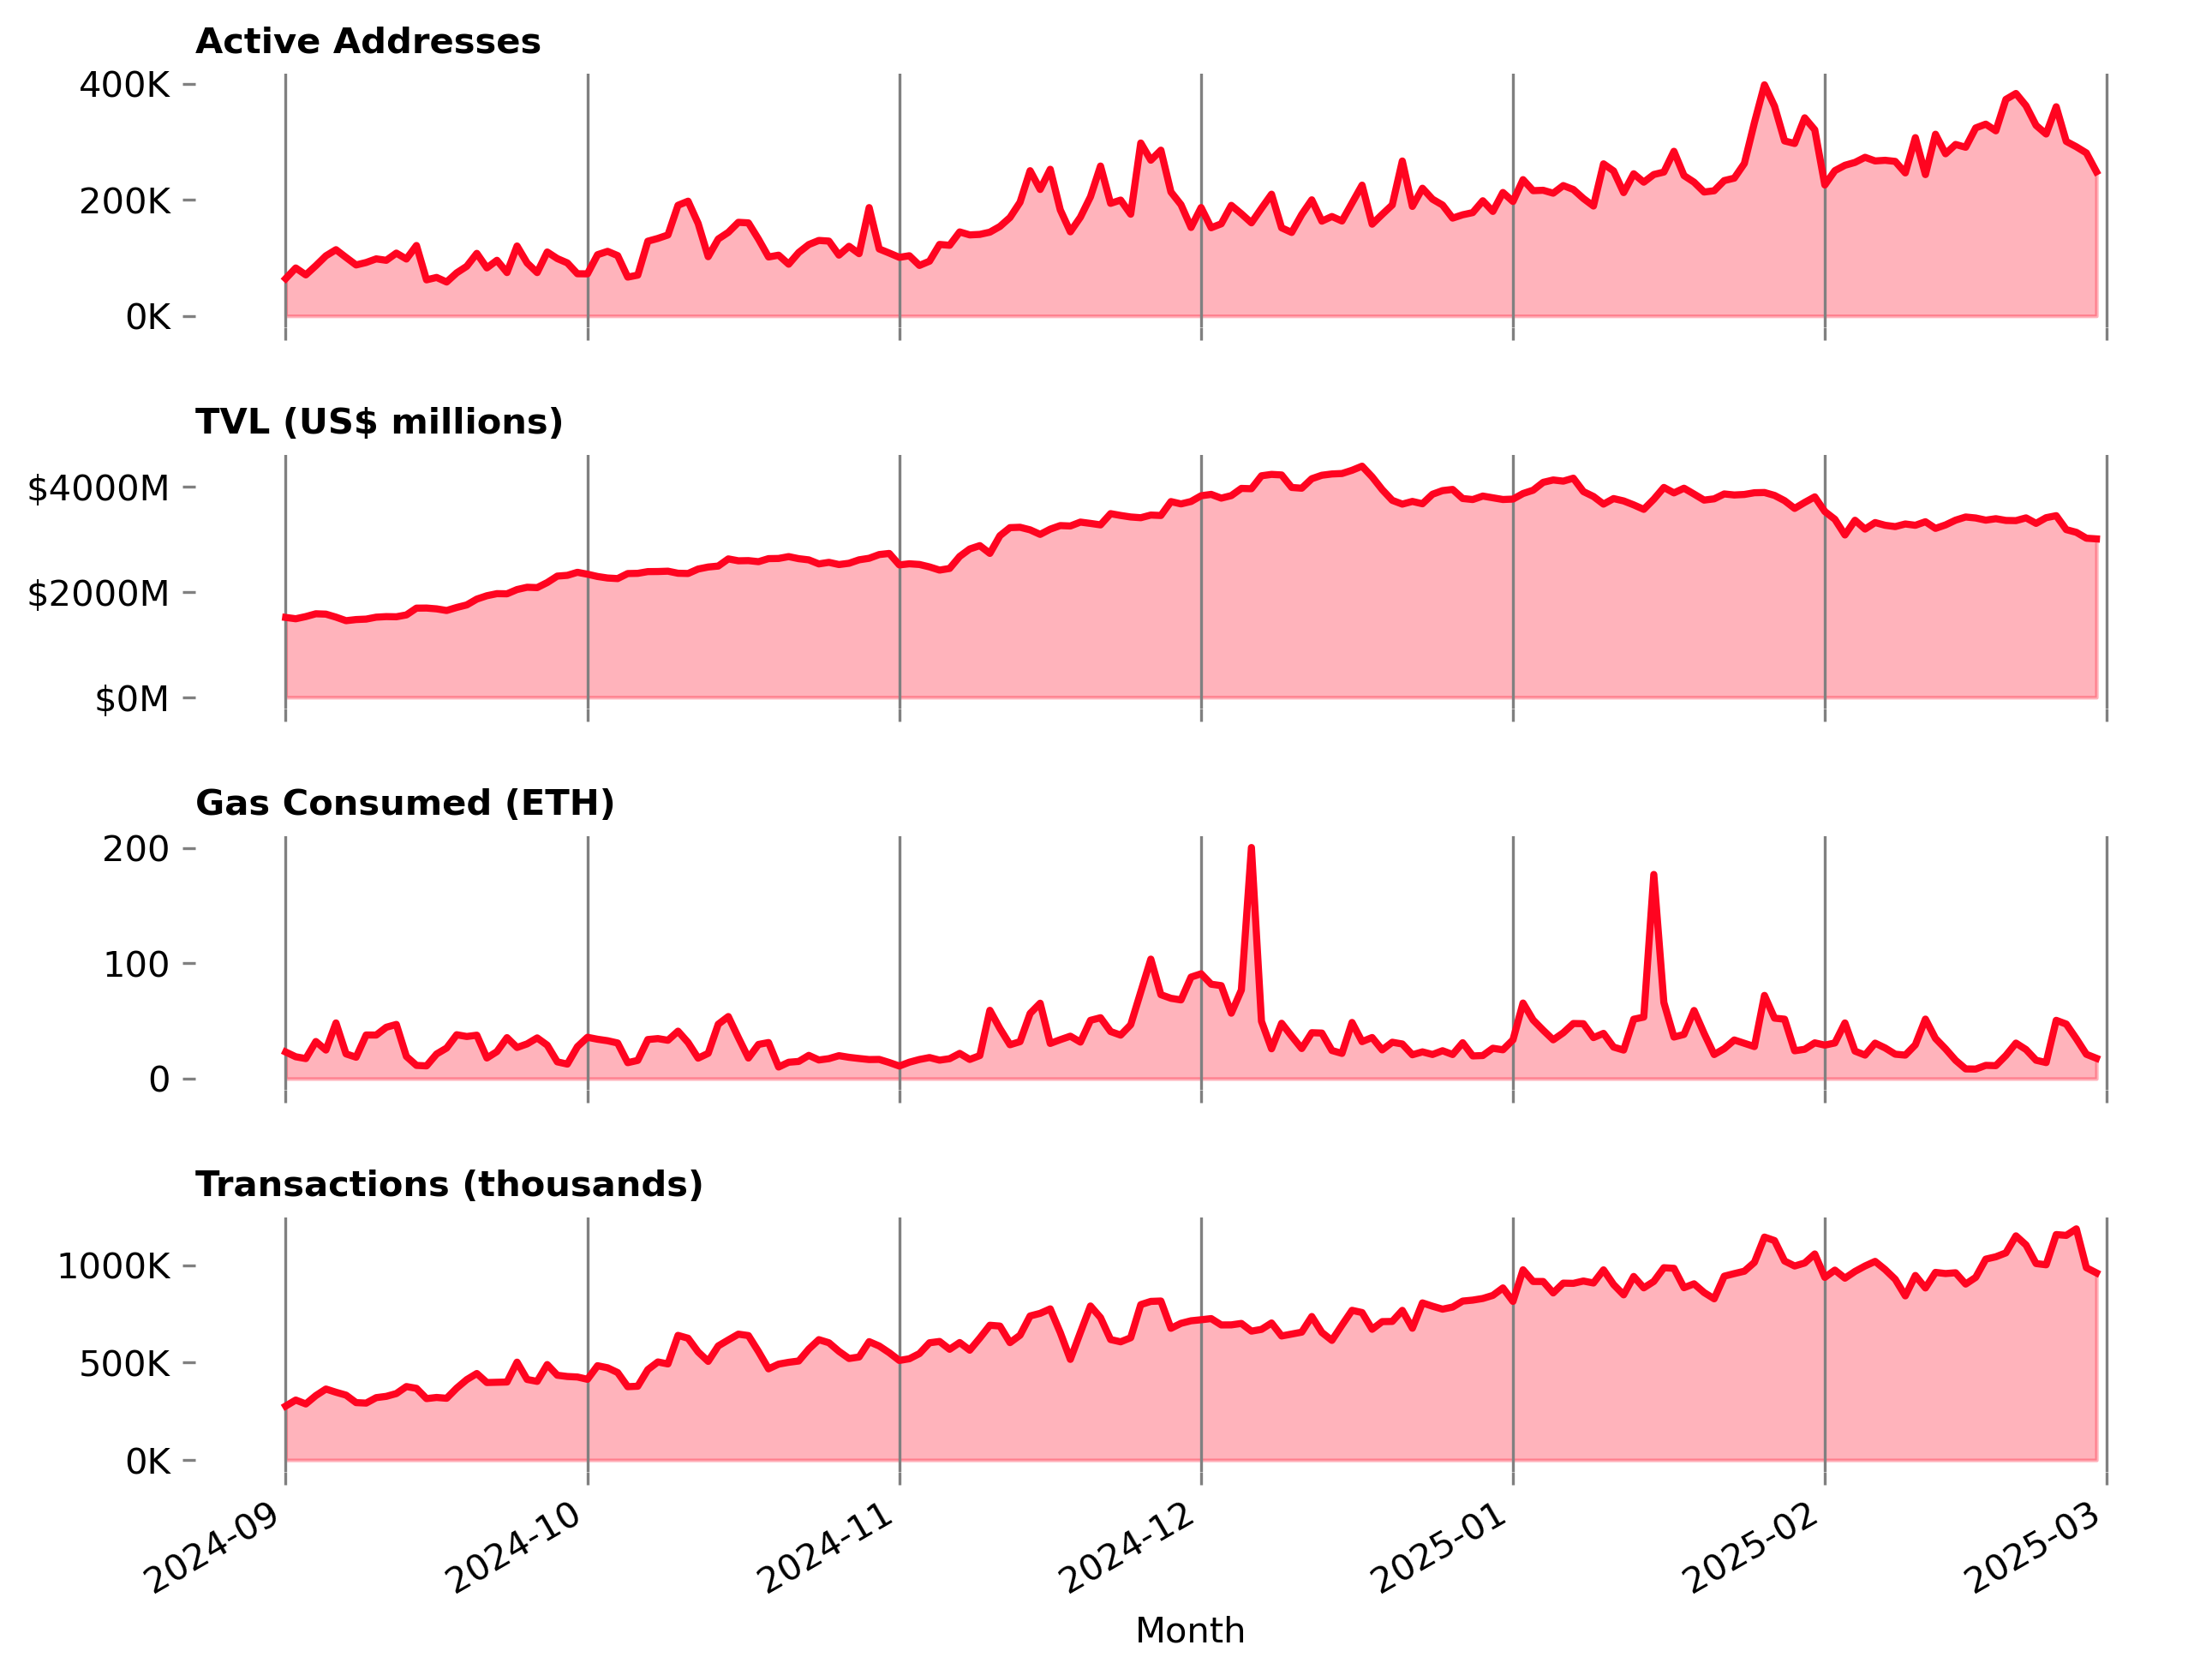

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates

df_onchain_metrics['sample_date'] = pd.to_datetime(df_onchain_metrics['sample_date'])

metric_categories_and_labels = {
    'Active Addresses Aggregation': 'Active Addresses',
    'Defillama TVL': 'TVL (US$ millions)',
    'Gas Fees': 'Gas Consumed (ETH)',
    'Transactions': 'Transactions (thousands)'
}

metric_categories = list(metric_categories_and_labels.keys())

line_color = '#ff0420'
shade_color = '#ff0420'
font_size = 10

scaling_factors = {
    'Active Addresses Aggregation': 1e-3,
    'Defillama TVL': 1e-6,
    'Gas Fees': 1,
    'Transactions': 1e-3
}

def millions_formatter(x, pos):
    return f'${x:.0f}M'

def thousands_formatter(x, pos):
    return f'{x:.0f}K'

fig, axes = plt.subplots(len(metric_categories), 1, sharex=True, figsize=(10, 8), dpi=300)

for ax, cat in zip(axes, metric_categories):

    data = df_onchain_metrics[df_onchain_metrics['metric_category'] == cat].sort_values('sample_date')
    
    scaling = scaling_factors.get(cat, 1)
    data = data.copy()
    data['scaled_amount'] = data['amount'] * scaling
    
    ax.plot(data['sample_date'], data['scaled_amount'], color=line_color, linewidth=2)
    ax.fill_between(data['sample_date'], data['scaled_amount'], color=shade_color, alpha=0.3)
    
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    ax.xaxis.grid(True, color='gray')
    
    ax.set_title(metric_categories_and_labels.get(cat, cat), fontsize=font_size, loc='left', weight='bold')
    ax.tick_params(axis='both', which='major', labelsize=font_size, color='gray', rotation=0)
    
    if cat == 'Defillama TVL':
        ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
    elif cat in ['Transactions', 'Active Addresses Aggregation']:
        ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

axes[-1].set_xlabel('Month', fontsize=font_size)
fig.autofmt_xdate()
fig.subplots_adjust(hspace=.5)

plt.show()

In [8]:
df_onchain_metrics['month'] = df_onchain_metrics['sample_date'].apply(lambda x: x.month)
onchain_summary = df_onchain_metrics.pivot_table(
    index='metric_category',
    columns='month',
    values='amount',
    aggfunc='sum'
)[[1,2]].map(int)
onchain_summary

month,1,2
metric_category,,
Active Addresses Aggregation,7866876,8259381
Contract Invocations,334594095,310576892
Defillama TVL,118992616554,92227038876
Gas Fees,1405,726
Transactions,29307847,28004378


## Devtooling

In [9]:
df_devtooling_projects = client.to_pandas(f"""
select
    p.project_id,
    p.project_name,
    p.display_name
from oso.projects_v1 p
join oso.projects_by_collection_v1 pbc on p.project_id = pbc.project_id
where pbc.collection_name = '7-1'
order by p.display_name
""")
DEVTOOLING_PROJECT_IDS = list(df_devtooling_projects['project_id'].unique())
df_devtooling_projects.set_index('project_id', inplace=True)
df_onchain_projects.tail()

,project_name,display_name
project_id,,
VTFjeAN76kGnqTqKP+SMe2HPaIKY3wKvwo613l6OWN0=,0x098fca4a62159ddfc2c45dc2931a727d56f039b8f68e...,pods.media
1TLTRUof21yQ9U4hpzbBFOxsAYwtkoq1KsBpe3xQgtk=,0xc3a50c1784f3ac4fc8ae72d07cf0bfcf933e3d23ffb5...,remx.xyz
2d1UftVv4xC+BHialsxoPjC1WJDySvOpnH9o+3sQFYc=,0x85bef37b528ec9d7e1a9cb864e298e3c117071507acd...,rhinofi
ujotQ1D+YnXHFVrSwoa3pj8b5jOvXNPF0rfALNIG5GI=,0xe95adf2385dce0a2d8117a410d0a9adcc40710da9cd6...,tinyass unicorns
514s67lKQTp5eW88EJW1fw6fMnCv2Gi3f1c+c36aHjk=,0x59fcf753703c0f32c9d601b7f0071304819e832262ef...,youbuidl


In [10]:
len(DEVTOOLING_PROJECT_IDS)

151

In [11]:
df_devtooling_metrics = client.to_pandas(f"""
select distinct
    artifact_name,
    updated_at,
    star_count,
    fork_count,
    num_packages_in_deps_dev
from int_repositories_enriched
where project_id IN ({stringify(DEVTOOLING_PROJECT_IDS)})
""")

In [12]:
print(len(df_devtooling_projects))
print(df_devtooling_metrics['num_packages_in_deps_dev'].sum())

151
3305


In [13]:
df_contributors = client.to_pandas(f"""
    select
        bucket_month,
        approx_distinct(from_artifact_id) as num_contributors,
        date_diff('month', bucket_month, current_date) as months_from_current
    from oso.int_events_monthly_to_project__github
    where
        event_type = 'COMMIT_CODE'
        and project_id IN ({stringify(DEVTOOLING_PROJECT_IDS)})
        and bucket_month < DATE('{END_DATE}')    
    group by bucket_month
    order by bucket_month
""")
df_contributors.set_index('months_from_current', inplace=True)

In [14]:
df_contributors.loc[2]

bucket_month        2025-02-01 00:00:00.000
num_contributors                        208
Name: 2, dtype: object

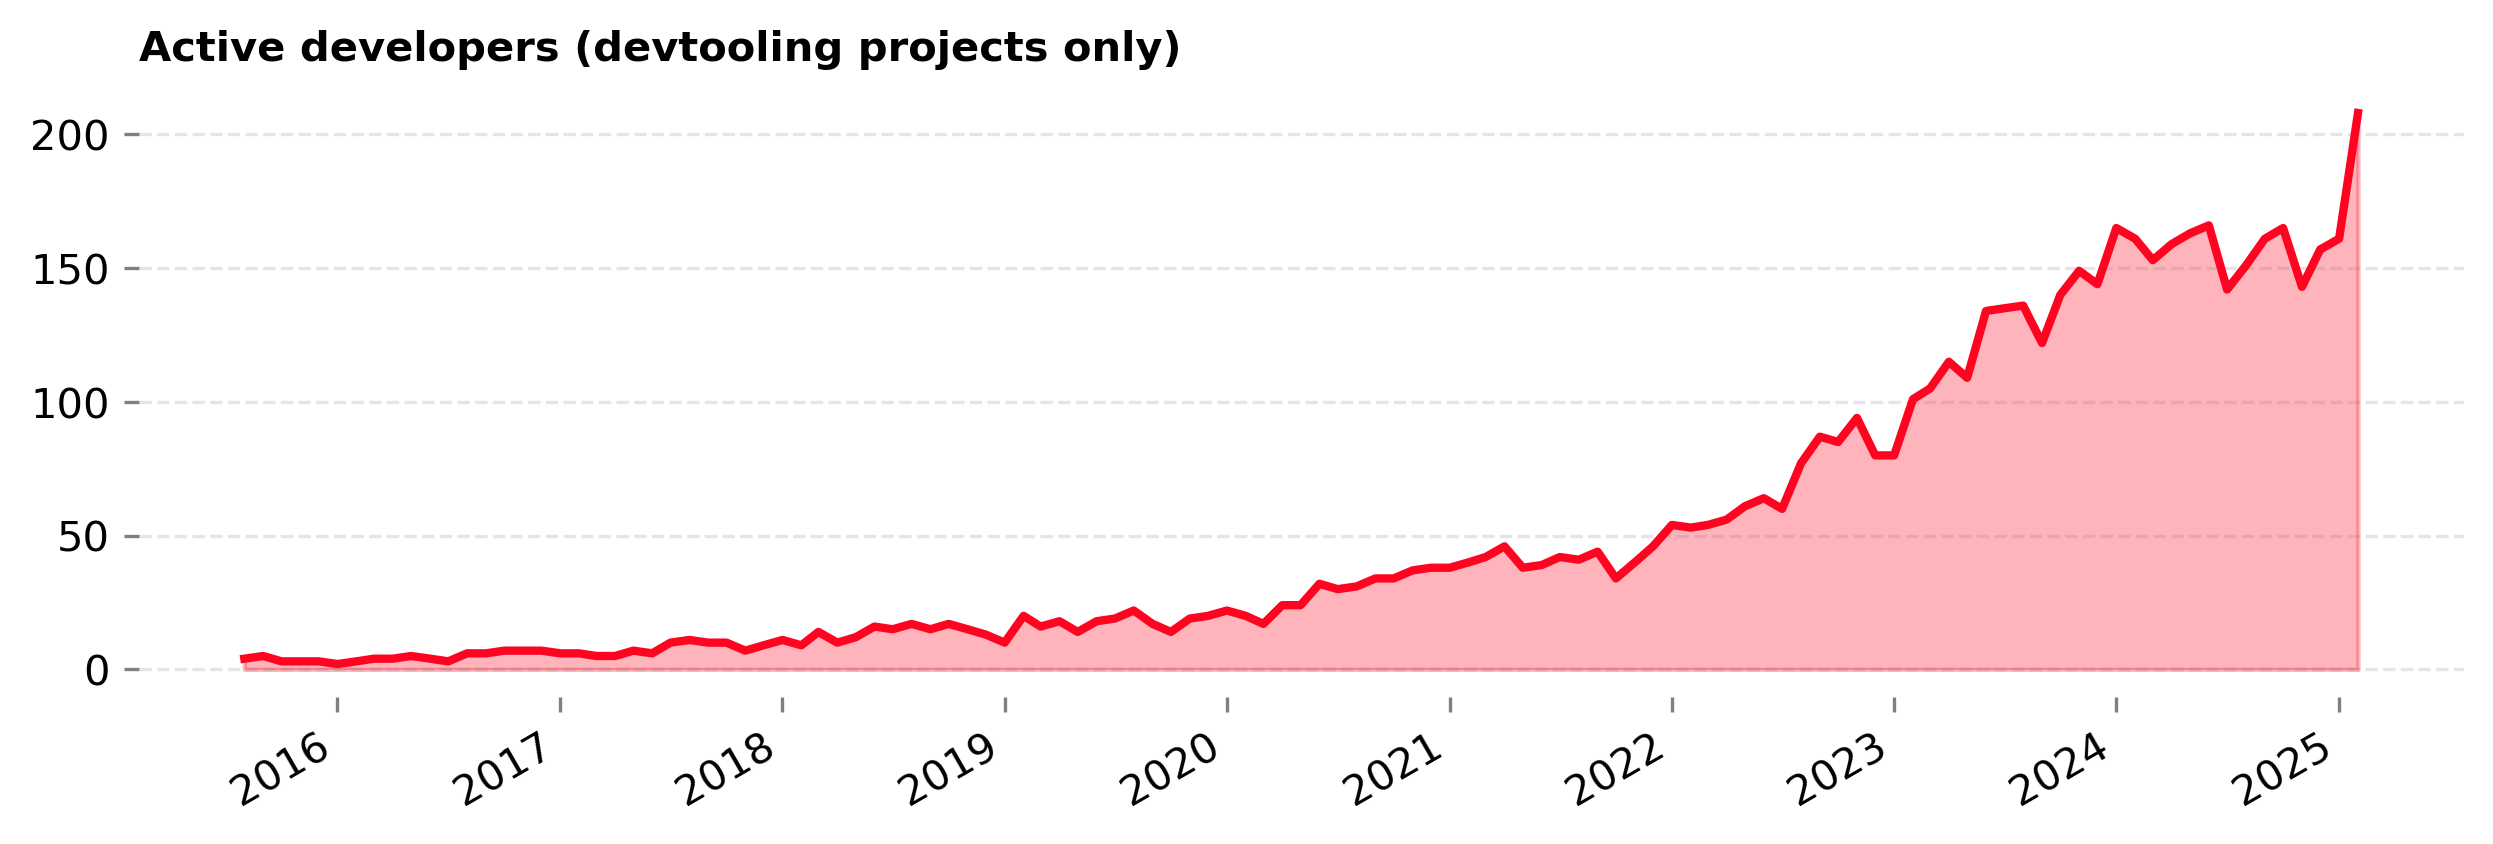

In [15]:
df_contributors['sample_date'] = pd.to_datetime(df_contributors['bucket_month'])

line_color = '#ff0420'
shade_color = '#ff0420'
font_size = 10

fig, ax = plt.subplots(figsize=(10, 3), dpi=300)

ax.plot(df_contributors['sample_date'], df_contributors['num_contributors'], color=line_color, linewidth=2)
ax.fill_between(df_contributors['sample_date'], df_contributors['num_contributors'], color=shade_color, alpha=0.3)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.yaxis.grid(True, color='gray', alpha=.2, linestyle='--')
ax.set_title("Active developers (devtooling projects only)", fontsize=font_size, loc='left', weight='bold')
ax.tick_params(axis='both', which='major', labelsize=font_size, color='gray', rotation=0)
    
ax.set_xlabel('', fontsize=font_size)
fig.autofmt_xdate()

plt.show()